In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import importlib
import sys
import copy
import os
from sklearn import preprocessing
from scripts.utils import time
import matplotlib.pyplot as plt

MAIN_DIR = 'C:/Users/nourisa/Downloads/testProjs/proteomics_MSC/'
OUTPUT_DIR = os.path.join(MAIN_DIR, 'results')
geneRNI_dir = os.path.join(MAIN_DIR,'..','geneRNI')
sys.path.insert(0, geneRNI_dir)

from geneRNI import geneRNI, tools, search_param
df_target = pd.read_csv('results/statAnalysis/df_sig.csv')
gene_names = list(df_target['Entry'].values)

def read_write_oo(study, mode, best_params=None, best_scores=None):
    '''
        Read and writes calibration results (best params and best scores) to file
    '''
    FILE = os.path.join(MAIN_DIR,'results/calibration',f'oo_{study}.txt')
    if mode == 'write':
        with open(FILE,'w') as f:
            print({'best_params':best_params, 'best_scores':best_scores},file=f)
    elif mode == 'read':
        with open(FILE,'r') as f:
            oo = eval(f.read())
        return oo['best_params'], oo['best_scores']

# Process the data
- Extract ctr and mg data from the time series

In [2]:
# extract ctr and mg data
df_ctr = df_target.loc[:,['ctr_'+str(day) for day in time]].T
df_mg = df_target.loc[:,['mg_'+str(day) for day in time]].T

# add mg as a regulatory factor with 0 for ctr and 1 for mg
# df_ctr['ctr_mg'] = np.zeros(len(time)) 
# df_mg['mg_mg'] = np.ones(len(time)) 
# gene_names.append('mg')

# normalize, equal variance
df_ctr_n = copy.deepcopy(df_ctr)
df_ctr_n.iloc[:,:] = preprocessing.scale(df_ctr.iloc[:,:])
df_mg_n = copy.deepcopy(df_mg)
df_mg_n.iloc[:,:] = preprocessing.scale(df_mg.iloc[:,:])

# get the data as arrays
data_ctr = df_ctr_n.values
data_mg = df_mg_n.values

# Run GRN using geneRNI framework
Steps:
- extract training data from the sig df
- add mg as a regulatory gene (0 for ctr and 1 for mg)
- combined the data of ctr and mg
- tune the param 
- extract regulatory links

In [17]:
# tune params using geneRNI: only train set
from geneRNI import search_param
importlib.reload(search_param)
specs = dict(
#     train_flag=True
)
param = dict(estimator_t = 'RF',random_state = 0)
param_grid = dict(alpha=np.arange(0,1,.05), min_samples_split=np.arange(2,5,1), min_samples_leaf=np.arange(1,5,1),max_depth=np.arange(10,20,1))
Xs_ctr, ys_ctr = tools.Data.process_time_series(TS_data=[data_ctr], time_points=[time], gene_names=gene_names)
Xs_mg, ys_mg = tools.Data.process_time_series(TS_data=[data_mg], time_points=[time], gene_names=gene_names)
print('Data shape:', np.array(ys_ctr).shape, '(n_samples_time_series*n_genes)')

def tune(Xs, ys, study):
    print(f'----Tuning for {study}-----')
    best_scores, best_params, best_ests, sampled_permts_sorted = \
            search_param.rand_search(Xs, ys, param=param, 
                                     param_grid=param_grid, 
                                     n_jobs=10, n_sample=60, 
                                     output_dir='results/calibration', **specs)
    read_write_oo(study, mode='write',best_params, best_scores)
    print(f'mean best score {np.mean(best_scores)}')
    return best_scores, best_params
# _ = tune(Xs_ctr, ys_ctr, study='ctr')
_ = tune(Xs_mg, ys_mg, study='mg')

Data shape: (48, 10) (n_samples_time_series*n_genes)
----Tuning for mg-----
stats: 48 genes 2400 permts 10 threads
Running 60 samples randomly
Permutation-based multi threading
Param search is completed in 58.605 seconds
mean best score 0.18886624070076832


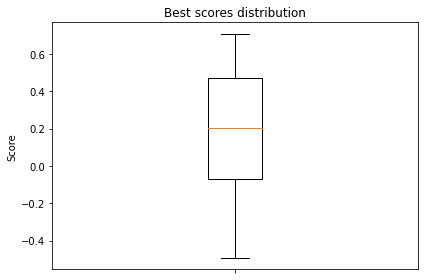

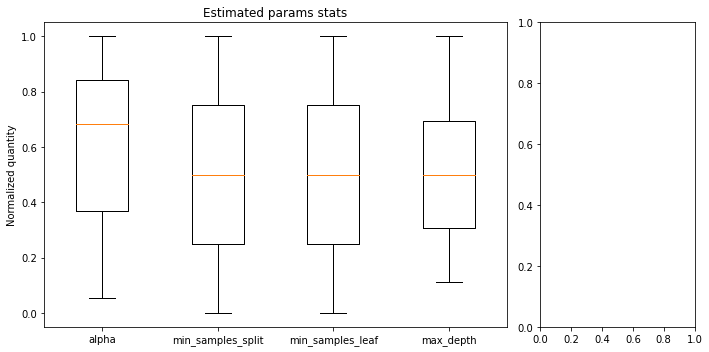

In [21]:
# box plots for best params and best scores
def plot(study):
    ''' 
         Plot best scores and best params
    ''' 
    # read the outputs of tunning
    best_params, best_scores = read_write_oo(study,mode='read')
    tools.GOF.boxplot_scores_single(best_scores)
    tools.GOF.boxplot_params(best_params, priors=param_grid, samples=None)
plot('mg')

In [23]:
# GRN
import importlib
import json
importlib.reload(tools)
importlib.reload(geneRNI)

def GRN(Xs, ys, study='ctr'):
    print(f'----GRN for {study}-----')
    # read the outputs of tunning
    best_params, best_scores = read_write_oo(study, mode='read')
    # run the network inference
    param = dict(estimator_t='RF', random_state=0)

    ests, train_scores, links_df, oob_scores, test_scores = \
        geneRNI.network_inference(Xs, ys, gene_names=gene_names, 
                                  param=param, param_unique=best_params, 
                                  Xs_test=None, ys_test=None, verbose=True
                                  )
    links_df.to_csv(os.path.join(MAIN_DIR,'results/GRN',f'geneRNI_{study}.csv'))
# GRN(Xs_ctr, ys_ctr, study='ctr')
GRN(Xs_mg, ys_mg, study='mg')

----GRN for mg-----

network inference: train score, mean: 0.888 std: 0.041
network inference: oob score (only RF), mean: 0.067 std: 0.34


## Filter genes with high test scores

In [11]:
# choose those genes with test score above the threshold 
test_score_t = .3
_, best_scores_ctr = read_write_oo(study='ctr', mode='read')
_, best_scores_mg = read_write_oo(study='mg', mode='read')
flag_ctr = np.array(best_scores_ctr) > test_score_t
flag_mg = np.array(best_scores_mg) > test_score_t
list(flag_mg*flag_ctr).count(True)

10

# # Run GRN using Portia

In [ ]:
# portia
dir_portia = os.path.join(MAIN_DIR,'..','external/PORTIA-master')
sys.path.insert(0,dir_portia)
import portia as pt

In [ ]:
dataset = pt.GeneExpressionDataset()
exp_id = 1
for data in df_ctr.values:
    dataset.add(pt.Experiment(exp_id, data))
    exp_id+=1
for data in df_mg.values:
    dataset.add(pt.Experiment(exp_id, data))
    exp_id+=1
print(f'n genes: {dataset.n_genes}, n samples: {dataset.n_samples}, n features: {dataset.n_features}')

In [ ]:
M_bar = pt.run(dataset, method='fast')
links_df = tools.Links.format(M_bar, gene_names)

# Porcess the links
- Compare the extracted links to ground truth (those extracted by STRINGS) 
- Visualize the links

In [5]:
# read the results
links_df = pd.read_csv(os.path.join(MAIN_DIR,'results/links.txt'), index_col=0)
# examinations
# links_df.loc[links_df['Regulator']=='mg']
# links_df.loc[links_df['Target']=='mg']

In [6]:
# make a shortlist of the links 
cut_off = np.quantile(links_df['Weight'],q=.9)
# apply the cutoff: selected links
links_df_s = links_df.loc[links_df['Weight']>cut_off,:]
# read outputs of string
STR_LINKS_FILE = os.path.join(MAIN_DIR,'string','string_interactions_short.tsv')

# extract links from string
df_links_str = df_links_str.rename(columns={'#node1':'Regulator','node2':'Target','combined_score':'Weight'})
df_links_str = df_links_str.loc[:,['Regulator','Target','Weight']]  

print(f'Number of string links: {len(df_links_str)}')
print(f'Number of extracted links: {len(links_df_s)}')
if len(df_links_str)>len(links_df_s):
    raise ValueError('Extracted links cannot be lesser than golden links')
# scale to have equal variance of 1
# df_links_str.loc[:,'Weight'] = preprocessing.scale(df_links_str.loc[:,'Weight'].values)
# df_s.loc[:,'Weight'] = preprocessing.scale(df_s.loc[:,'Weight'].values)
print(f"Golden, mean: {np.mean(df_links_str.loc[:,'Weight'])} std: {np.std(df_links_str['Weight'])}")
print(f"Extracted, mean: {np.mean(links_df_s['Weight'])} std: {np.std(links_df_s['Weight'])}")

# how many of string links are included in the extracted links
regs = df_links_str['Regulator'].values
targs = df_links_str['Target'].values
pairs = [(reg,targ) for reg,targ in zip(regs, targs)]
found = []
for pair in pairs:
    step1_df = links_df_s.loc[links_df_s['Regulator']==gene_maps[pair[0]],:]
    found.append(np.any(step1_df['Target'] == gene_maps[pair[1]]))
print(f'Number of matched links: {np.count_nonzero(np.array(found))}')

Number of string links: 58
Number of extracted links: 226
Golden, mean: 0.6209482758620688 std: 0.19735932767712114
Extracted, mean: 0.0762228065353657 std: 0.049656224040413456
Number of matched links: 8


### Visualize

In [7]:
# calculate sum of outgoing links
import copy
sum_ws = [sum(links_df.loc[links_df['Regulator']==gene,:]['Weight']) for gene in gene_names]
df_sum_ws = pd.DataFrame(data={'Entry':gene_names,'SumWeight':sum_ws})
df_sum_ws_s = df_sum_ws.sort_values('SumWeight')
vertex_sizes = sum_ws
# replace the names with indices: index of the genes in the gene_names
df_s = copy.deepcopy(links_df_s)
df_s.loc[:,'Regulator'] = [gene_names.index(name) for name in list(df_s['Regulator'].values)]
df_s.loc[:,'Target'] = [gene_names.index(name) for name in list(df_s['Target'].values)]
edges = df_s.loc[:,['Regulator','Target']].values
weights = df_s['Weight'].values
print(f'number of links to visualize {len(df_s)}')

number of links to visualize 226


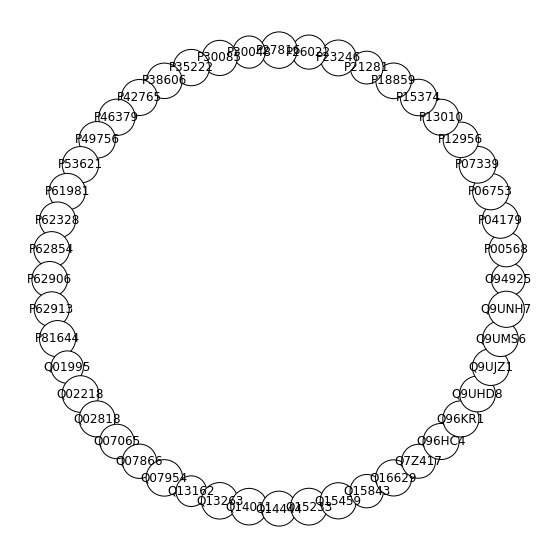

In [13]:
# visualize the links
import igraph as ig
import matplotlib.pyplot as plt

# Construct a graph with 3 vertices
n_vertices = len(gene_names)
g = ig.Graph(n_vertices, edges=None, directed=False)

# Set attributes for the graph, nodes, and edges
g["title"] = "Regulatory network"
g.vs["name"] = gene_names
g.vs["weights"] = weights
g.vs["vertex_sizes"] = vertex_sizes
# Plot in matplotlib
fig, ax = plt.subplots(figsize=(10,10))
vertex_size_correction = .4/np.max(vertex_sizes)
edge_size_correction = 2/np.max(weights)
ig.plot(
    g,
    target=ax,
    layout="kk",
    vertex_size=[x*vertex_size_correction for x in g.vs["vertex_sizes"]],
    vertex_color="white",
#     vertex_frame_width=8,
#     vertex_frame_color="white",
    vertex_label=g.vs["name"],
    vertex_label_size=12,
    edge_width=[x*edge_size_correction for x in weights],
    edge_arrow_width = .5
#     edge_color=["#7142cf" if x>np.mean(g.es['weights']) else "#AAA" for married in g.es["married"]]
)
ig.Graph.community_fastgreedy(g)
plt.show()

# Save the graph as an image file
fig.savefig('RGN.png') 

# Vester’s Sensitivity Model (VSM)
- AS: active sum. Sum along rows of the influence matrix and it indicates how much does a variable influence all the others.
- PS: passive sum. Its is the sum along columns of the influence matrix and it indicates how sensitive a variable is, how does it react to the influence of others
- Q: AS/PS -> how dominant
- P: AS.PS -> how participative a variable is
- Active: +Q
- Passive: -Q, -P
- Critical: +Q, +P
- Buffering: -Q, -P

In [ ]:
# import the inputs
links_df = pd.read_csv(os.path.join(MAIN_DIR,'results/links.txt'), index_col=0)
# calculate AS and PS
AS = [sum(links_df.loc[links_df['Regulator']==gene,:]['Weight']) for gene in gene_names]
PS = [sum(links_df.loc[links_df['Target']==gene,:]['Weight']) for gene in gene_names] 
df_sum = pd.DataFrame(data={'Entry':gene_names,'AS':AS, 'PS':PS})

In [ ]:
class Plot:
    linewidth = 2
    markers = ['o','o','o','*']
    colors = ['green','blue','magenta','r']
    sizes = [30*i for i in [1,1.5,2,5]]
    @staticmethod
    def mark_y(ax, y_t):
        """
        Markline for the sig
        """
        line_color = 'grey'
        dx = ax.get_xlim()
        ax.axhline(y_t,color='grey', linestyle='-.')
    @staticmethod
    def mark_x(ax, x_t):
        """
        Markline for fold change
        """
        line_color = 'grey'
        ax.axvline(x_t,color=line_color, linestyle='--',linewidth=Plot.linewidth)
    @staticmethod
    def scatter(ax,PS, AS, roles):
        import matplotlib.markers as mmarkers
        sc = ax.scatter(PS,AS,
                   color=[Plot.colors[i] for i in roles],
#                    alpha=[1 if flag else .5 for flag in flags]
#                    alpha = .7,
                   linewidths=.5,
                   edgecolors='black',
                  s = [Plot.sizes[i] for i in roles],
                  )
        markers = [Plot.markers[i] for i in roles]
        paths = []
        for marker in markers:
            marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
 
    def print_roles(ax):
        fontsize = 10
        LD = [0.1,0.05]
        RD = [1.4,0.05]
        LU = [0.1,.88]
        RU = [1.4,.88]
        ax.annotate('Buffering', LD, fontsize=fontsize)
        ax.annotate('Passive', RD, fontsize=fontsize)
        ax.annotate('Active', LU, fontsize=fontsize)
        ax.annotate('Critical', RU, fontsize=fontsize)
    def print_names(ax, AS, PS, gene_names, roles):
        '''
            Prints names of critical genes on the scatter plot
        '''
        fontsize = 7
        offset = .05
        for i, gene_name in enumerate(gene_names):
            role = roles[i]
            if role != 3: #just critical 
                continue
            x = PS[i]
            y = AS[i]
            
            ax.annotate(gene_name, (x-2*offset,y-offset), fontsize=fontsize)

    @staticmethod
    def postprocess(ax, title, x_t, y_t):
        ax.set_xlabel('Passive Sum')
        ax.set_ylabel('Active Sum')
#         ax.set_xlim([-1.2*Plot.max_diff, 1.2*Plot.max_diff])
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
def plot_1(df_ctr, df_mg):
    '''
        Plots AS/PS for ctr and mg conditions.
    '''
    rows = 1
    cols = 2
    fig, axes = plt.subplots(rows, cols, tight_layout=True, figsize=(cols*4, rows*4))
    dfs = [df_ctr, df_mg]
    titles = ['Control','Mg']
    for j in range(cols):
        df = dfs[j]
        if df is None:
            continue
        ax = axes[j]
        # define the roles
        AS = df['AS'].values
        PS = df['PS'].values
        x_t = (max(PS)-min(PS))/2 + min(PS)
        y_t = (max(AS)-min(AS))/2 + min(AS)
        y_flags = AS>y_t
        x_flags = PS>x_t
        roles = [2*y_flag+x_flag for x_flag, y_flag in zip(x_flags,y_flags)]
        # visualize
        Plot.scatter(ax,PS=PS, AS=AS, roles=roles)
        Plot.mark_x(ax,x_t)
        Plot.mark_y(ax, y_t)
        Plot.print_roles(ax)
        Plot.print_names(ax=ax, AS=AS, PS=PS, gene_names=gene_names, roles=roles)
        Plot.postprocess(ax, title=titles[j], x_t=x_t, y_t=y_t)
    fig.savefig(os.path.join(OUTPUT_DIR, 'roles_ctr_mg.pdf'))
plot_1(df_sum,None)